<a href="https://colab.research.google.com/github/aseltmann/colabs-for-fcs/blob/main/notebooks/Extract_FCS_from_widefield_camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Written by Alex Seltmann, 2023. Github for license, versions, issues, etc: https://github.com/aseltmann/colabs-for-fcs

Citation: TBD

In [1]:
#@title # **1. Import modules** { vertical-output: true, display-mode: "form" }
#@markdown ---
!pip install stackview
!pip install multipletau
!pip install prettyprinter

from __future__ import annotations

import multipletau
import stackview

import imageio.v3 as iio
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as ski

from dataclasses import dataclass, field
from datetime import datetime
from pathlib import Path
from prettyprinter import pprint, install_extras
from scipy import ndimage as ndi
from tqdm.notebook import tqdm
from typing import Literal, Union

install_extras(['dataclasses', 'numpy'])

logging.basicConfig(format='%(asctime)s - build model -  %(message)s')
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

def extract_fcs(tif: np.ndarray, mask: np.ndarray,
                divide_by_number_of_pixels: bool):
    """Extract binned FCS trace from tif

    Parameters
    ----------
    tif: np.array of int or float
        1. dimension: image stack
        2. + 3. dimension: image width and height
    mask : np.array of bool
        2D mask (image width and height). Where True, the intensity is extracted
    divide_by_number_of_pixels: bool
        if True, divide the extracted intensity by the number of pixels.
    """
    if not isinstance(tif, np.ndarray) & isinstance(mask, np.ndarray):
        raise TypeError('tif and mask should be np.ndarrays (or subclasses like '
                        'imageio.core.util.Array), but are '
                        f'{type(tif)=} and {type(mask)=}')

    if not mask.dtype == bool:
        raise TypeError('mask should contain values of type bool, but contains'
                        f'{mask.dtype=}')

    tif_instance = mask.reshape((1, *mask.shape)).repeat(len(tif), axis=0)
    tif_instance = np.where(tif_instance > 0, tif, 0)

    result = np.sum(tif_instance, axis=(1, 2))

    if divide_by_number_of_pixels:
        no_of_pixels = mask.sum()
        result /= no_of_pixels

    return result

def photon_counting_stats(time_series, time_series_scale):
    """returns counting statistics

    Notes
    -----
    - code is adopted from Dominic Waithe's Focuspoint package:
    https://github.com/dwaithe/FCS_point_correlator/blob/master/focuspoint/correlation_objects.py"""
    unit = time_series_scale[-1] / len(time_series_scale)
    # Converts to counts per
    kcount_ch = np.average(time_series)
    # This is the unnormalised intensity count for int_time duration (the first
    # moment)
    raw_count = np.average(time_series)
    var_count = np.var(time_series)

    brightness_nandb_ch = (((var_count - raw_count) / (raw_count)) /
                           (float(unit)))
    if (var_count - raw_count) == 0:
        number_nandb_ch = 0
    else:
        number_nandb_ch = (raw_count**2 / (var_count - raw_count))
    return kcount_ch, brightness_nandb_ch, number_nandb_ch

def save_extracted_correlation(out_file, corr_fn, parent_name, kcount,
                               brightness_nandb, number_nandb):
    autotime = corr_fn[:, 0]
    autonorm = corr_fn[:, 1]

    # compatibility with FoCuS-fit-JS:
    # with 'w': utf-16le (doesn't work), utf-8 (works)
    # with 'wb': works with .encode() behind strings
    with open(out_file, 'w', encoding='utf-8') as out:
        out.write('version,3.0\n')
        # this is a pure autocorrelation function, so set num_ch=1
        out.write(f'numOfCH,1\n')
        out.write('type,point\n')
        out.write(f'parent_name,{parent_name}\n')
        out.write(f'ch_type,1_1\n')
        out.write(f'kcount,{kcount}\n')
        out.write(f'numberNandB,{number_nandb}\n')
        out.write(f'brightnessNandB,{brightness_nandb}\n')
        out.write('carpet pos,0\n')
        out.write('pc,0\n')
        out.write(f'Time (ms),CH1 Auto-Correlation\n')
        for i in range(autotime.shape[0]):
            out.write(f'{autotime[i]},{autonorm[i]}\n')
        out.write('end\n')


#-@dataclass
# class FCSCorrelation:
#     name: str
#     method: Literal['tttr2xfcs', 'multipletau']
#     channel1: int
#     channel2: int
#     count1: int = field(default=0, compare=False)
#     count2: int = field(default=0, compare=False)
#     kcount: Union[int, float, None] = None
#     brightness_nandb: Union[int, float, None] = None
#     number_nandb: Union[int, float, None] = None
#     autotime: np.ndarray = field(default=np.zeros(1), compare=False)
#     autonorm: np.ndarray = field(default=np.zeros(1), compare=False)


#-@dataclass
# class FCSTimeSeries:
#     """Holds exactly one FCS time series including """
#     name: str
#     channel: int
#     bin: float
#     size: int
#     kcount: Union[int, float, None]
#     brightness_nandb: Union[int, float, None]
#     number_nandb: Union[int, float, None]
#     trace: np.ndarray
#     scale: np.ndarray
#     correlation: Union[FCSCorrelation, None] = None


@dataclass
class FCSfromTIF:
    original_tif: np.ndarray
    standardized_metadata: iio.core.v3_plugin_api.ImageProperties
    tif_metadata: dict | None
    summed_tif: np.ndarray | None = None
    normalized_tif: np.ndarray | None = None
    bg_dict: dict[Literal['fixed', 'min', 'avg', 'roll'],
                  int | float | np.ndarray] = field(default_factory=dict)
    bg_corrected: dict[str, bool] = field(default_factory=dict)
    seg_dict: dict[str, np.ndarray] = field(default_factory=dict)
    _original_timeseries_dict: dict[str, np.ndarray] = field(default_factory=dict)
    timeseries_dict: dict[str, np.ndarray] = field(default_factory=dict)
    ts_scale_dict: dict[str, np.ndarray] = field(default_factory=dict)
    correlation_dict: dict[str, np.ndarray] = field(default_factory=dict)
    lag_time_dict: dict[str, np.ndarray] = field(default_factory=dict)

    def background_correction(self, record_key: str,
                              method: Literal["fixed", "min", "avg", "roll"]):
        """Apply background correction to FCS time series extracted from tif
        The following 4 background correction methods are available
        * `fixed`: substract fixed background.
        * `min`: substract minimum background value per frame
        * `avg`: substract average of background pixels per frame
        * `roll`: substract rolling mean of average of background pixels per frame.
        """
        if not self.bg_dict:
            raise ValueError('No background values found.')
        if not method in self.bg_dict:
            raise ValueError(f'{method=} is not a valid method.')
        if not record_key in self.timeseries_dict:
            raise ValueError(f'{record_key=} is not a valid key to get a '
                            'time series from record.')
        if self.bg_corrected.get(record_key):
            ts = self._original_timeseries_dict[record_key]
        else:
            ts = self.timeseries_dict[record_key]
            self._original_timeseries_dict[record_key] = ts
            self.bg_corrected[record_key] = True

        self.timeseries_dict[record_key] = ts - self.bg_dict[method]


# **2. Upload your data**
---

In [ ]:
#@title ##**2a) Upload your data from your local files** { vertical-output: true, display-mode: "form" }
#@markdown * Run this cell and click "Choose files" to upload files to this Colab session
#@markdown * These files are saved in the `/content/` directory and as a dictionary
#@markdown in the variable `uploaded`
#@markdown * these files are only available in your session. Your session ends
#@markdown after being idle for 90min or after 12 hours running time.
#@markdown * You can use around 70-80GB disk space
from google.colab import files
uploaded = files.upload()

print()
print(f'The dictionary `uploaded` holds the following keys: {uploaded.keys()=}')


The dictionary `uploaded` holds the following keys: uploaded.keys()=dict_keys([])


In [2]:
#@title ##**2b) Connect your Colab to Google Drive to access your data** { vertical-output: true, display-mode: "form" }

# old method:
# Click on the URL.
# Sign in your Google Account.
# Copy the authorization code.
# Enter the authorization code.

# new method:
#@markdown * execute this code block and click on "Allow" when you are asked if
#@markdown you want to allow Colab access to your Drive.
#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".


#mounts user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#@title  { vertical-output: true, display-mode: "form" }
#@markdown * Right-click on the Google Drive folder containing your data (currently only 1 `.tif` file) and select "Copy path"
#@markdown * **Note: if possible, save the `.tif` files as an image stack. Reading thousands of files takes a long time**
#@markdown * Paste the folder path here:
# test file 1: /content/gdrive/MyDrive/Colab Notebooks Data/extract FCS from widefield camera - data/80% 100µs.tif
# test file 2: /content/gdrive/MyDrive/Colab Notebooks Data/extract FCS from widefield camera - data/20000-5ms+0,043-35pz_1_MMStack_Default.ome.tif
uploaded = '/content/gdrive/MyDrive/Colab Notebooks Data/extract FCS from widefield camera - data/20000-5ms+0,043-35pz_1_MMStack_Default.ome.tif' #@param {type:"string"}
uploaded = Path(uploaded)
if uploaded.is_file:
    files = [uploaded]
else:
    files = [f for f in uploaded.rglob('*.tif')]
pprint(f'Prepared paths: {files[:10]}', width=160)

"Prepared paths: [PosixPath('/content/gdrive/MyDrive/Colab Notebooks "
"Data/extract FCS from widefield camera - "
"data/20000-5ms+0,043-35pz_1_MMStack_Default.ome.tif')]"


# **3. Load `.tif` file and compute mask for FCS extraction**
---

INFO:__main__:There was an error while loading the TIF file. Attempting to load again without TIF metadata...


tif_sum_min=2202795.0, tif_sum_max=2713460.0, tif_sum_min<tif_sum_max=True


StackViewNDArray([[0.0383167 , 0.10266809, 0.11358131, ..., 0.16715655,
                   0.20255549, 0.19254306],
                  [0.08576072, 0.07147151, 0.11356173, ..., 0.2115751 ,
                   0.22934408, 0.16166371],
                  [0.07934752, 0.07745391, 0.14650112, ..., 0.17761546,
                   0.17924275, 0.12458266],
                  ...,
                  [0.07475351, 0.07911449, 0.10020659, ..., 0.39389423,
                   0.3806096 , 0.26105765],
                  [0.05943818, 0.07322805, 0.09658583, ..., 0.32272038,
                   0.3400938 , 0.18869708],
                  [0.05611506, 0.04454584, 0.09033515, ..., 0.21458295,
                   0.28027573, 0.2007872 ]], dtype=float32)
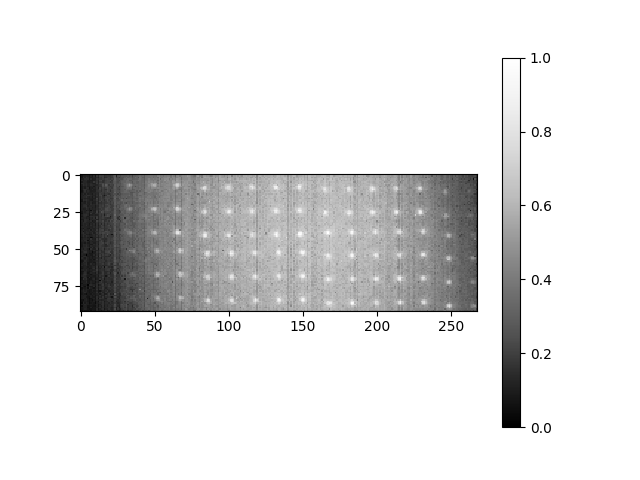
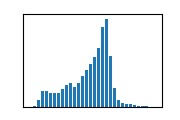

In [3]:
#@title ##**3.1. Load volume, sum intensities along stack and normalize**
if len(files) == 1:
    try:
        tif_metadata = iio.immeta(files[0])
    except ValueError:
        log.info('There was an error while loading the TIF file. Attempting to'
                 ' load again without TIF metadata...')
        tif_metadata = None
    tifdc = FCSfromTIF(original_tif=iio.imread(files[0]),
                        tif_metadata=tif_metadata,
                        standardized_metadata=iio.improps(files[0]))
else:
    raise ValueError('Reading more than 1 file is not yet implemented')


# prevents integer overflow when computing min and max values
tifdc.original_tif = tifdc.original_tif.astype(np.float32)
tifdc.summed_tif = tifdc.original_tif.sum(axis=0)
tif_sum_min = tifdc.summed_tif.min()
tif_sum_max = tifdc.summed_tif.max()

print(f'{tif_sum_min=}, {tif_sum_max=}, {tif_sum_min<tif_sum_max=}')

# min-max normalization
tifdc.normalized_tif = ((tifdc.summed_tif - tif_sum_min) /
                        (tif_sum_max - tif_sum_min))
# simple normalization
# tif_norm = (tif_sum / tif_max) * 255

# define constants for plotting
XSIZE = 9
YSIZE = tifdc.standardized_metadata.shape[0] // XSIZE
YSIZE = YSIZE if YSIZE >= 3 else 3

stackview.insight(tifdc.normalized_tif)

<ipython-input-4-fc73fcfcd3fc>:18: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  im_mean = ski.filters.rank.mean(im, im_neighborhood)


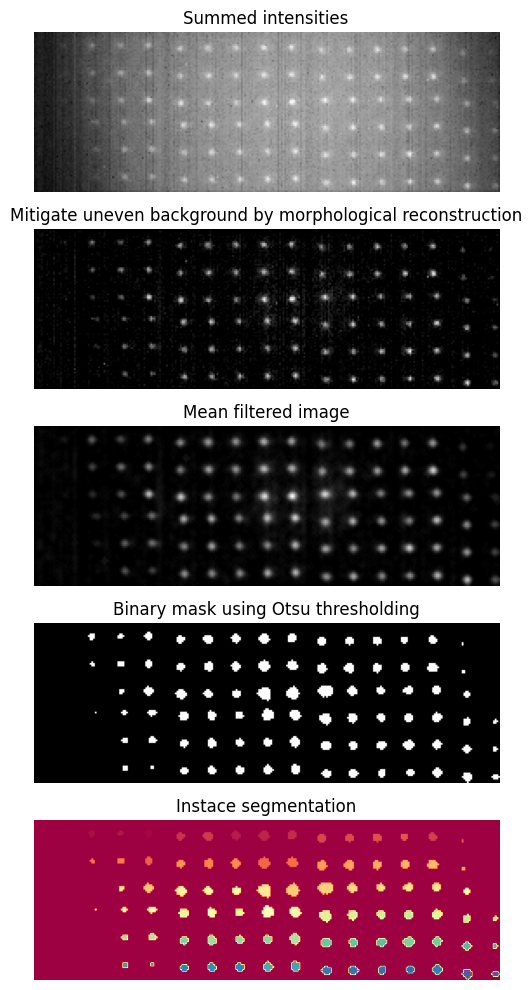

In [4]:
#@title ##**3.2. Instance segmentation** { display-mode: "form" }
#@markdown * If the following is ticked, uneven background is removed by
#@markdown [morphological reconstruction](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_regional_maxima.html)
mitigate_uneven_illumination = True #@param {type:"boolean"}

im = tifdc.normalized_tif.copy()
if mitigate_uneven_illumination:
    # first, correct uneven illumination - see:
    # https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_regional_maxima.html
    seed = tifdc.normalized_tif.copy()
    seed[1:-1, 1:-1] = im.min()
    dilated = ski.morphology.reconstruction(seed=seed, mask=im,
                                            method='dilation')
    im -= dilated

# second, perform mean filtering for more robust otsu thresholding
im_neighborhood = ski.morphology.disk(2)
im_mean = ski.filters.rank.mean(im, im_neighborhood)
# im_mean = ski.filters.gaussian(im, 1.5)

# third, otsu thresholding for semantic segmentation
thresh_mean = ski.filters.threshold_otsu(im_mean)
tifdc.seg_dict['full_mask'] = im_mean > thresh_mean

# fourth, instance segmentation
markers, num_features = ndi.label(tifdc.seg_dict['full_mask'])


nsubplots = 5 if mitigate_uneven_illumination else 4
fig, axes = plt.subplots(nsubplots, figsize=(XSIZE, YSIZE), sharex=True,
                         sharey=True)
ax = axes.ravel()

ax[0].imshow(tifdc.normalized_tif, cmap="gray")
ax[0].set_title('Summed intensities')
if mitigate_uneven_illumination:
    ax[1].imshow(im, cmap="gray")
    ax[1].set_title('Mitigate uneven background by morphological reconstruction')
ax[nsubplots - 3].imshow(im_mean, cmap="gray")
ax[nsubplots - 3].set_title('Mean filtered image')
ax[nsubplots - 2].imshow(tifdc.seg_dict['full_mask'], cmap="gray")
ax[nsubplots - 2].set_title('Binary mask using Otsu thresholding')
ax[nsubplots - 1].imshow(markers, cmap="Spectral")
ax[nsubplots - 1].set_title('Instace segmentation')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

# **4. Extract FCS from instances**
---

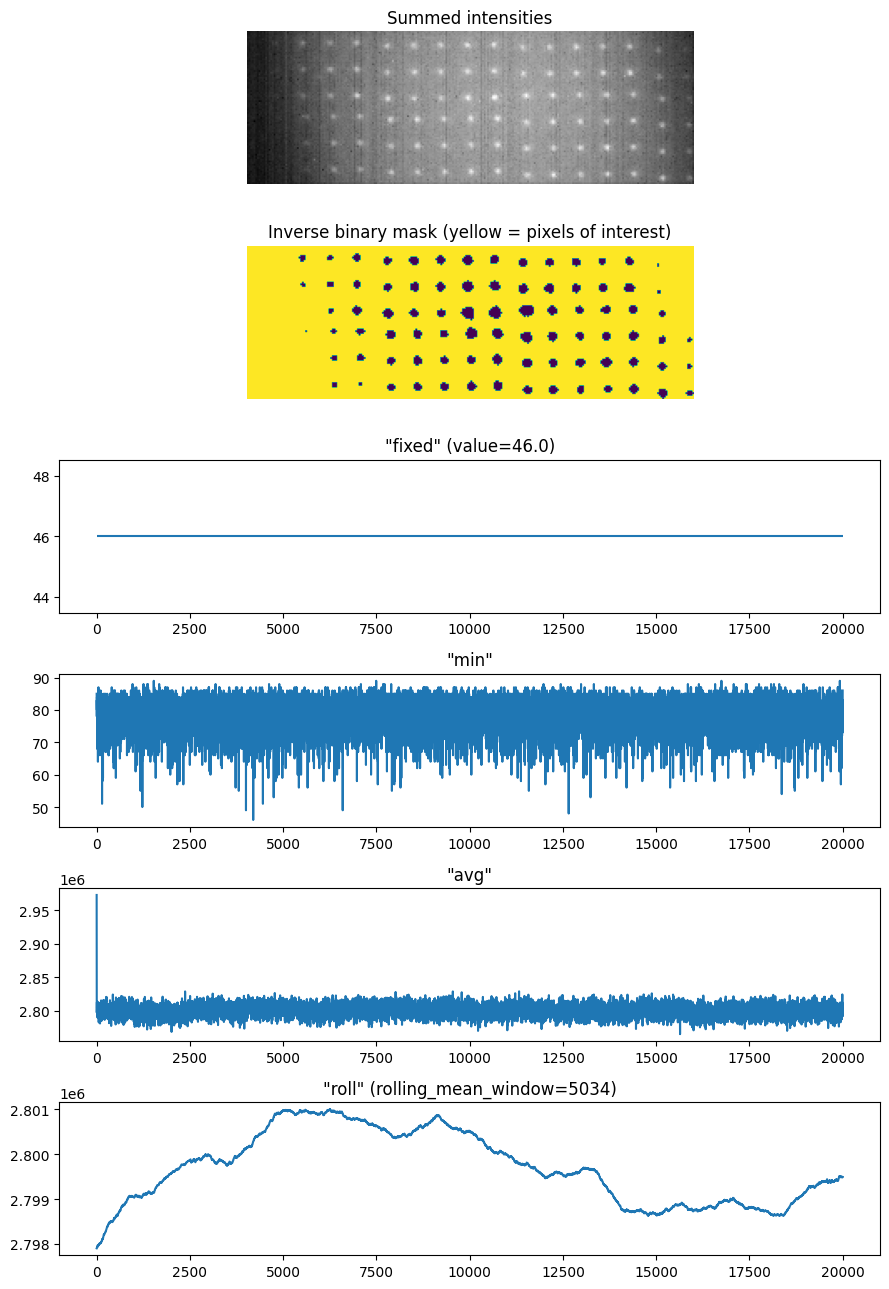

In [7]:
#@title ##**(Optional) 4.0. Inspect inverse mask for background correction** { display-mode: "form" }
#@markdown The following 4 background correction methods are available
#@markdown * `fixed`: substract fixed background. Currently, this value is
#@markdown automatically set as the minimum pixel value in the whole image stack.
#@markdown * `min`: substract minimum background value per frame
#@markdown * `avg`: substract average of background pixels per frame
#@markdown * `roll`: substract rolling mean of average of background
#@markdown pixels per frame. Choose the window here:

# ---------------------------- USER INPUT ------------------------------------
rolling_mean_window = 5034 #@param {type:"slider", min:0, max:10000, step:1}

#@markdown * check, if you want to normalize the intensity by dividing by the
#@markdown number of pixels. **If you apply background correction in the next
#@markdown cell, this parameter should stay the same**
divide_by_number_of_pixels = False #@param {type:'boolean'}
# ---------------------------- COMPUTATION -----------------------------------
tifdc.bg_dict['fixed'] = tifdc.original_tif.min()

# get minimum value of only background pixels (inverse binary mask) over time
mask = ~tifdc.seg_dict['full_mask']
no_of_pixels = mask.sum()
tif_instance = mask.reshape((1, *mask.shape)).repeat(
    len(tifdc.original_tif), axis=0)
tif_instance = np.where(tif_instance > 0,
                        tifdc.original_tif,
                        tifdc.original_tif.max())
tifdc.bg_dict['min'] = tif_instance.min(axis=(1, 2))

# get sum of all background pixels over time
tifdc.bg_dict['avg'] = extract_fcs(tifdc.original_tif, mask,
                                   divide_by_number_of_pixels)

# get rolling average
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return (pd.DataFrame(a).rolling(n, center=True, min_periods=1).
            mean().to_numpy().flatten())
tifdc.bg_dict['roll'] = rollavg_pandas(a=tifdc.bg_dict['avg'],
                                       n=rolling_mean_window)
# -------------------------------- PLOT ------------------------------------
fig, axes = plt.subplots(6, figsize=(XSIZE, YSIZE+3))
ax = axes.ravel()

ax[0].imshow(tifdc.summed_tif, cmap="gray")
ax[0].set_title('Summed intensities')
ax[1].imshow(mask)
ax[1].set_title('Inverse binary mask (yellow = pixels of interest)')
ax[2].hlines(y=tifdc.bg_dict['fixed'], xmin=0, xmax=len(tifdc.bg_dict['avg']))
ax[2].set_title(f'"fixed" (value={tifdc.bg_dict["fixed"]})')
ax[3].plot(tifdc.bg_dict['min'])
ax[3].set_title('"min"')
ax[4].plot(tifdc.bg_dict['avg'])
ax[4].set_title('"avg"')
ax[5].plot(tifdc.bg_dict['roll'])
ax[5].set_title(f'"roll" ({rolling_mean_window=})')


for a in ax[:-4]:
    a.set_axis_off()

fig.tight_layout()
plt.show()

INFO:__main__:Extracting 84 FCS time series and correlations...


  0%|          | 0/83 [00:00<?, ?it/s]

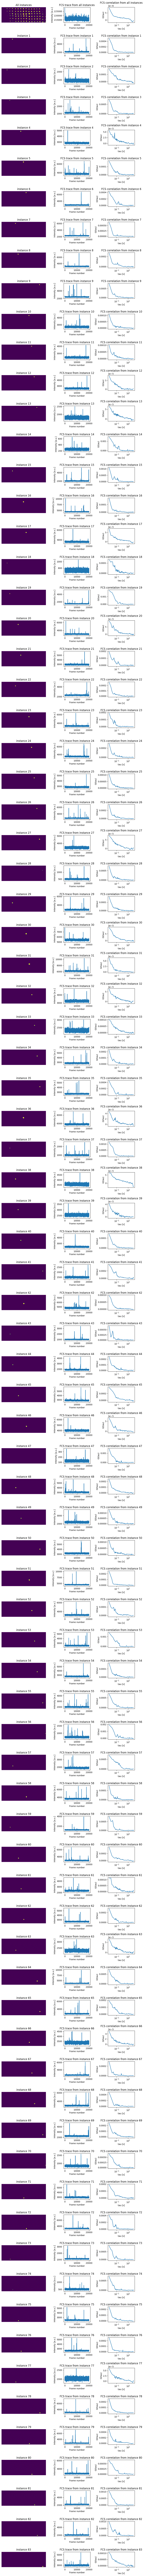

In [10]:
#@title ##**4.1. Extract FCS traces** { display-mode: "form" }
# ----------------------------- USER INPUT ------------------------------------
# save_out_csv_of_traces = True #@param {type:'boolean'}
save_out_csv_of_correlations = False #@param {type:'boolean'}

out_path = '/content/gdrive/MyDrive/Colab Notebooks Data/extract FCS from widefield camera - data/test output' #@param {type: 'string'}
out_path = Path(out_path)
if not out_path.is_dir():
    raise ValueError('out_path should be a directory.')

#@markdown ---
#@markdown * provide the distance between the bins (`deltat` $[s]$) of your
#@markdown time trace for correlation via `multipletau`
deltat = 5e-3 #@param {type:'number'}
cut_correlation_function = False #@param {type:'boolean'}
#@markdown * if you checked `cut_correlation_function`, provide a maximum lag
#@markdown time $\tau$ after which to cut off the correlation function
cut_at = 1 #@param {type:"number"}
#@markdown * Choose background correction. The values for substraction are taken
#@markdown from **Section 4.0**, which has to be executed before.
apply_background_correction = "none" #@param ["none", "fixed", "min", "avg", "roll"]
#@markdown * check, if you want to normalize the intensity from one region by
#@markdown dividing by the number of pixels of that region. **If you apply
#@markdown background correction, this parameter should stay the same**
divide_by_number_of_pixels = False #@param {type:'boolean'}

# ----------------- PREPARE PLOT AND EXTRACT FIRST FCS (ALL INSTANCES) ---------


timestamp = datetime.today().isoformat(sep='-', timespec="seconds").replace(':', '')
out_basic = f'{timestamp}-{uploaded.stem}'.replace('%', '')
out_traces = out_path / f'{out_basic}-traces.csv'

# extract full FCS trace
tifdc.timeseries_dict['full_mask'] = extract_fcs(tifdc.original_tif,
                                                 tifdc.seg_dict['full_mask'],
                                                 divide_by_number_of_pixels)
if apply_background_correction != 'none':
    tifdc.background_correction(record_key='full_mask',
                                method=apply_background_correction)
# tifdc.ts_scale_dict['full_mask'] = np.linspace(
#     start=0, stop=len(tifdc.original_tif) * deltat, num=len(tifdc.original_tif))
tifdc.ts_scale_dict['full_mask'] = np.arange(0, len(tifdc.original_tif))

# correlate full FCS trace
corr_fn = multipletau.autocorrelate(
                a=tifdc.timeseries_dict['full_mask'],
                m=16,
                deltat=deltat,
                normalize=True)

if cut_correlation_function:
    corr_mask = corr_fn[:, 0] < cut_at
    corr_mask = np.repeat(corr_mask.reshape(-1, 1), 2, axis=1)
    corr_fn = corr_fn[corr_mask].reshape((-1, 2))

tifdc.lag_time_dict['full_mask'] = corr_fn[1:, 0]
tifdc.correlation_dict['full_mask'] = corr_fn[1:, 1]

# extract FCS trace for each instance
fig, axes = plt.subplots(num_features, 3, figsize=(9, num_features*2),
                         gridspec_kw={'width_ratios': [5, 3, 3]})
ax = axes.ravel()

ax[0].imshow(tifdc.seg_dict['full_mask'])
ax[0].set_title('All instances')
ax[1].plot(tifdc.ts_scale_dict['full_mask'],
           tifdc.timeseries_dict['full_mask'])
ax[1].set_title(f'FCS trace from all instances')
plt.setp(ax[1], xlabel='Frame number', ylabel='Intensity [a.u.]')
ax[2].semilogx(tifdc.lag_time_dict['full_mask'],
               tifdc.correlation_dict['full_mask'])
ax[2].set_title(f'FCS correlation from all instances')

plt.setp(ax[2], xlabel='tau [s]', ylabel='G(tau)', ylim=[None, None])

if save_out_csv_of_correlations:
    out_correlation = out_path / f'{out_basic}-correlation_all_instances.csv'
    pcs_results = photon_counting_stats(tifdc.timeseries_dict['full_mask'],
                                        tifdc.ts_scale_dict['full_mask'])
    save_extracted_correlation(out_correlation, corr_fn[1:, :], out_basic,
                               *pcs_results)

# ----------------------- EXTRACT AND PLOT SINGLE INSTANCES -------------------
log.info('Extracting %s FCS time series and correlations...', num_features)
columns = ['delta_t_in_ms', 'all_instances']
for i in tqdm(range(1, num_features)):
    name = f'instance_{i:0>2}'
    columns.append(name)
    # segmentation mask
    tifdc.seg_dict[name] = np.where(markers == i, True, False).astype(bool)
    # time series
    tifdc.timeseries_dict[name] = extract_fcs(tifdc.original_tif,
                                              tifdc.seg_dict[name],
                                              divide_by_number_of_pixels)
    if apply_background_correction != 'none':
        tifdc.background_correction(record_key=name,
                                    method=apply_background_correction)

    # correlation
    corr_fn = multipletau.autocorrelate(
        a=tifdc.timeseries_dict[name],
        m=16,
        deltat=deltat,
        normalize=True)
    if cut_correlation_function:
        corr_mask = corr_fn[:, 0] < cut_at
        corr_mask = np.repeat(corr_mask.reshape(-1, 1), 2, axis=1)
        corr_fn = corr_fn[corr_mask].reshape((-1, 2))
    tifdc.lag_time_dict[name] = corr_fn[1:, 0]
    tifdc.correlation_dict[name] = corr_fn[1:, 1]

    ax[i*3].imshow(tifdc.seg_dict[name])
    ax[i*3].set_title(f'instance {i}')
    ax[i*3+1].plot(tifdc.ts_scale_dict['full_mask'],
                   tifdc.timeseries_dict[name])
    ax[i*3+1].set_title(f'FCS trace from instance {i}')
    plt.setp(ax[i*3+1], xlabel='Frame number', ylabel='Intensity [a.u.]')
    ax[i*3+2].semilogx(tifdc.lag_time_dict[name],
                       tifdc.correlation_dict[name])
    ax[i*3+2].set_title(f'FCS correlation from instance {i}')

    plt.setp(ax[i*3+2], xlabel='tau [s]', ylabel='G(tau)', ylim=[None, None])
    if save_out_csv_of_correlations:
        out_correlation = out_path / f'{out_basic}-correlation_{name}.csv'
        pcs_results = photon_counting_stats(tifdc.timeseries_dict[name],
                                            tifdc.ts_scale_dict['full_mask'])
        save_extracted_correlation(out_correlation, corr_fn[1:, :], out_basic,
                                   *pcs_results)

for a in [a for a in ax if not 'FCS' in a.title.get_text()]:
    a.set_axis_off()
# if save_out_csv_of_traces:
#     out = pd.DataFrame(out, columns=columns)
#     out.to_csv(out_traces)

fig.tight_layout()
plt.show()